In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
jj_data = pd.read_csv('dataset/jj.csv')
jj_data['date'] = pd.to_datetime(jj_data['date'])
# jj_data.set_index('date', inplace=True)
print(jj_data)

         date   data
0  1960-01-01   0.71
1  1960-04-01   0.63
2  1960-07-02   0.85
3  1960-10-01   0.44
4  1961-01-01   0.61
..        ...    ...
79 1979-10-01   9.99
80 1980-01-01  16.20
81 1980-04-01  14.67
82 1980-07-02  16.02
83 1980-10-01  11.61

[84 rows x 2 columns]


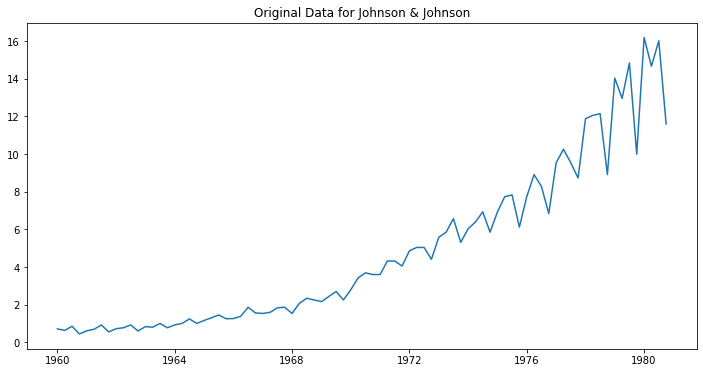

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'].to_numpy(), jj_data['data'].to_numpy())
plt.title('Original Data for Johnson & Johnson')
plt.show()

In [4]:
rolmean = jj_data['data'].rolling(window=12).mean()
rolvar = jj_data['data'].rolling(window=12).var()  

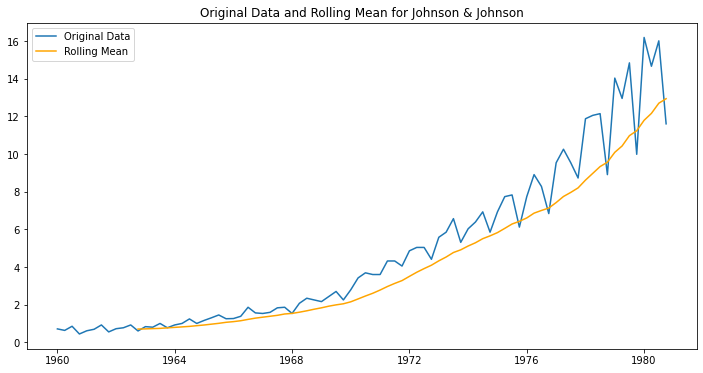

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'].to_numpy(), jj_data['data'].to_numpy(), label='Original Data')
plt.plot(jj_data['date'].to_numpy(), rolmean.to_numpy(), label='Rolling Mean', color='orange')
plt.title('Original Data and Rolling Mean for Johnson & Johnson')
plt.legend()
plt.show()

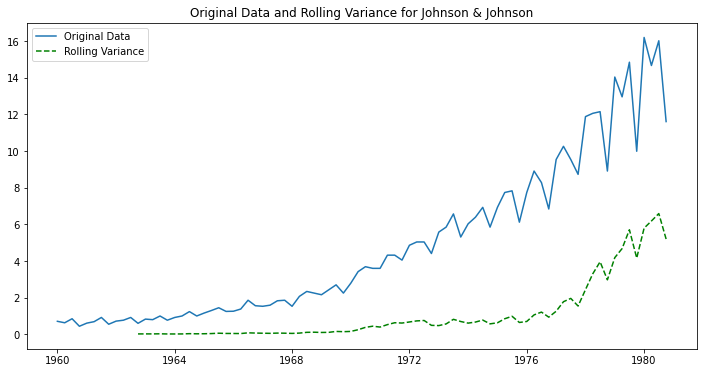

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'].to_numpy(), jj_data['data'].to_numpy(), label='Original Data')
plt.plot(jj_data['date'].to_numpy(), rolvar.to_numpy(), label='Rolling Variance', color='green', linestyle='dashed') 
plt.title('Original Data and Rolling Variance for Johnson & Johnson')
plt.legend()
plt.show()

In [7]:
result = adfuller(jj_data['data'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Johnson & Johnson is Stationary (reject the null hypothesis)")
else:
    print("Johnson & Johnson is Non-stationary (fail to reject the null hypothesis)")

ADF Statistic: 2.7420165734574735
p-value: 1.0
Critical Values: {'1%': -3.524624466842421, '5%': -2.9026070739026064, '10%': -2.5886785262345677}
Johnson & Johnson is Non-stationary (fail to reject the null hypothesis)


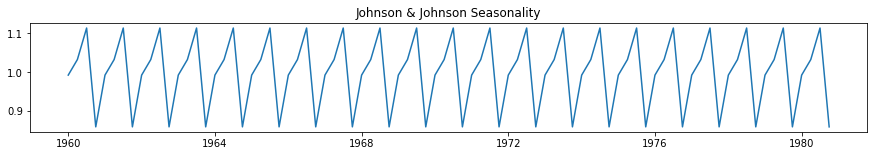

In [8]:
result = seasonal_decompose(jj_data['data'], model='multiplicative', period=4)

plt.figure(figsize=(15, 2))
plt.plot(jj_data['date'].to_numpy(), result.seasonal.to_numpy())
plt.title('Johnson & Johnson Seasonality')
plt.show()

In [9]:
def differencing(data):
    q = 0
    while(True):
        result = adfuller(data)
        if result[1] <= 0.01:
            break
        data = np.log(data)
        data = data.diff().dropna()
        q += 1
    return data, q

In [10]:
jj_data_stationary = jj_data[:]

In [11]:
jj_data_stationary['data'], optimal_d = differencing(jj_data['data'])

In [12]:
jj_data_stationary = jj_data_stationary.dropna()

In [13]:
jj_data_stationary

,date,data
1,1960-04-01,-0.119545
2,1960-07-02,0.299517
3,1960-10-01,-0.658462
4,1961-01-01,0.326684
5,1961-04-02,0.123233
...,...,...
79,1979-10-01,-0.396415
80,1980-01-01,0.483427
81,1980-04-01,-0.099207
82,1980-07-02,0.088033


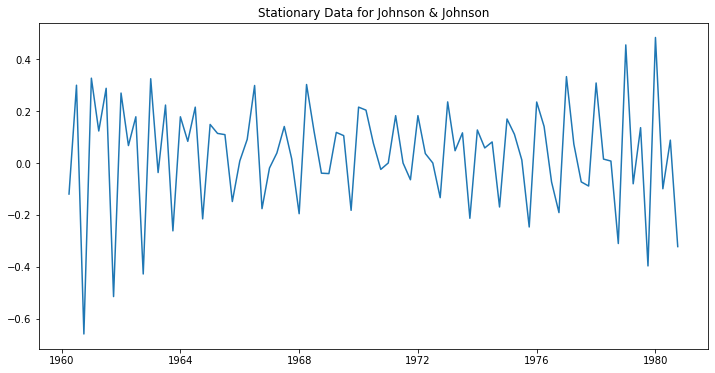

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(jj_data_stationary['date'].to_numpy(), jj_data_stationary['data'].to_numpy())
plt.title('Stationary Data for Johnson & Johnson')
plt.show()

In [15]:
result = adfuller(jj_data_stationary['data'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Johnson & Johnson is Stationary (reject the null hypothesis)")
else:
    print("Johnson & Johnson is Non-stationary (fail to reject the null hypothesis)")

ADF Statistic: -4.317043945811843
p-value: 0.00041497314044405543
Critical Values: {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
Johnson & Johnson is Stationary (reject the null hypothesis)


In [16]:
train_end = pd.to_datetime('1976-10-01')
test_end = pd.to_datetime('1980-10-01')

train_data = jj_data_stationary[jj_data_stationary['date'] <= train_end].drop(columns=['date'])
test_data = jj_data_stationary[(jj_data_stationary['date'] > train_end) & (jj_data_stationary['date'] <= test_end)].drop(columns=['date'])

In [17]:
train_data

,data
1,-0.119545
2,0.299517
3,-0.658462
4,0.326684
5,0.123233
...,...
63,-0.246400
64,0.234840
65,0.140773
66,-0.073331


In [18]:
test_data

,data
68,0.332706
69,0.072759
70,-0.072759
71,-0.088728
72,0.308091
73,0.015038
74,0.007435
75,-0.310155
76,0.454736
77,-0.080043


In [19]:
pacf_values, pacf_confint = pacf(jj_data_stationary['data'], alpha=0.05)
significant_lags = np.where(np.abs(pacf_values) > pacf_confint[:, 1])[0]

print("Significant Lags based on PACF:")
print(significant_lags)

optimal_p = max(significant_lags, default=1)
print("\nOptimal p based on PACF:")
print(optimal_p)

Significant Lags based on PACF:
[1 2 3 6]

Optimal p based on PACF:
6


<Figure size 864x1440 with 0 Axes>

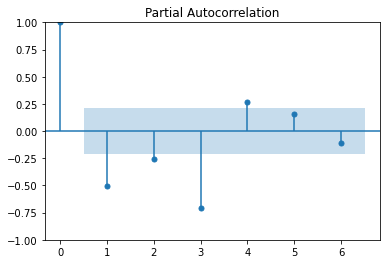

In [20]:
plt.figure(figsize=(12, 20))
plot_pacf(jj_data_stationary['data'], lags=optimal_p)   
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\srina\appdata\local\programs\python

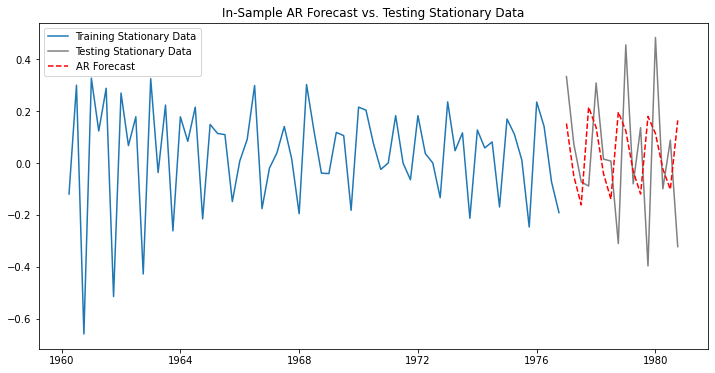

Optimal lag order (p) based on PACF: 6
RMSE (AR): 0.2938320891004463
R-squared (AR): -0.3195325851019717
MSE (AR): 0.0863372965851326
MAPE (AR): 2.649977480667639%


In [21]:
AR_model = ARIMA(train_data, order=(optimal_p, 0, 0))
results = AR_model.fit()

AR_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(jj_data_stationary['date'][:len(train_data)].to_numpy(), train_data.to_numpy(), label='Training Stationary Data')
plt.plot(jj_data_stationary['date'][len(train_data):].to_numpy(), test_data.to_numpy(), label='Testing Stationary Data', color='gray')
plt.plot(jj_data_stationary['date'][len(train_data):].to_numpy(), AR_forecast.to_numpy(), label='AR Forecast', color='red', linestyle='--')
plt.title('In-Sample AR Forecast vs. Testing Stationary Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, AR_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, AR_forecast)
mape = mean_absolute_percentage_error(test_data, AR_forecast)

print(f"Optimal lag order (p) based on PACF: {optimal_p}")
print(f"RMSE (AR): {rmse}")
print(f"R-squared (AR): {r2}")
print(f"MSE (AR): {mse}")
print(f"MAPE (AR): {mape}%")

In [22]:
acf_values, acf_confint = acf(jj_data_stationary['data'], alpha=0.05)
significant_lags = np.where(np.abs(acf_values) > acf_confint[:, 1])[0]

print("Significant Lags based on ACF:")
print(significant_lags)

optimal_q = max(significant_lags, default=1)
print("\nOptimal q based on ACF:")
print(optimal_q)

Significant Lags based on ACF:
[ 1  3  5  7  9 11]

Optimal q based on ACF:
11


<Figure size 864x1440 with 0 Axes>

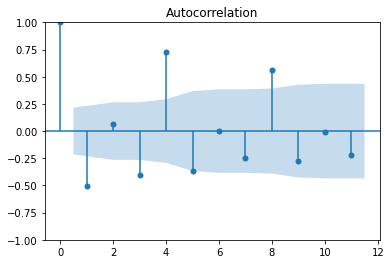

In [23]:
plt.figure(figsize=(12, 20))
plot_acf(jj_data_stationary['data'], lags=optimal_q)   
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\srina\appdata\local\programs\python

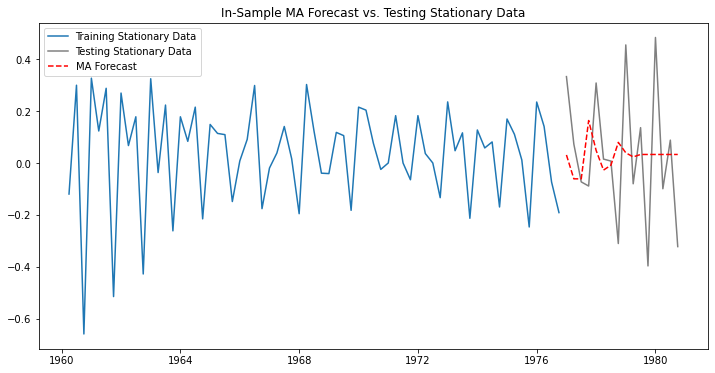

Optimal lag order (q) based on ACF: 11
RMSE (MA): 0.26476262140186474
R-squared (MA): -0.07135899014292946
MSE (MA): 0.07009924569158715
MAPE (MA): 1.3027047554019227%


In [24]:
MA_model = ARIMA(train_data, order=(0, 0, optimal_q))
results = MA_model.fit()

MA_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(jj_data_stationary['date'][:len(train_data)].to_numpy(), train_data.to_numpy(), label='Training Stationary Data')
plt.plot(jj_data_stationary['date'][len(train_data):].to_numpy(), test_data.to_numpy(), label='Testing Stationary Data', color='gray')
plt.plot(jj_data_stationary['date'][len(train_data):].to_numpy(), MA_forecast.to_numpy(), label='MA Forecast', color='red', linestyle='--')
plt.title('In-Sample MA Forecast vs. Testing Stationary Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, MA_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, MA_forecast)
mape = mean_absolute_percentage_error(test_data, MA_forecast)

print(f"Optimal lag order (q) based on ACF: {optimal_q}")
print(f"RMSE (MA): {rmse}")
print(f"R-squared (MA): {r2}")
print(f"MSE (MA): {mse}")
print(f"MAPE (MA): {mape}%")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\app

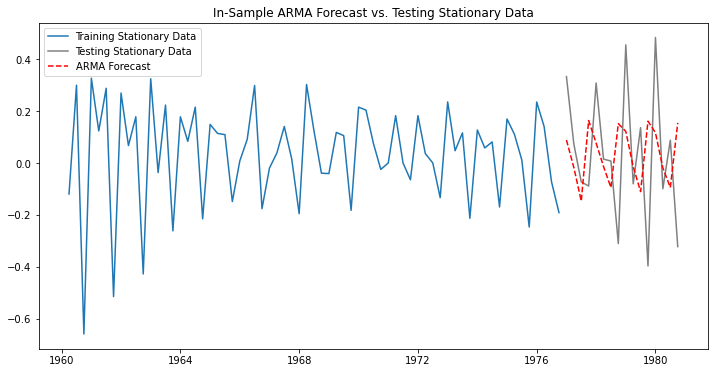

Optimal lag order (p, q) based on PACF and ACF: (6, 11)
RMSE (ARMA): 0.28534478272037395
R-squared (ARMA): -0.24440442304244514
MSE (ARMA): 0.08142164502573743
MAPE (ARMA): 2.0967676609226684%


In [25]:
ARMA_model = ARIMA(train_data, order=(optimal_p, 0, optimal_q))
results = ARMA_model.fit()

ARMA_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(jj_data_stationary['date'][:len(train_data)].to_numpy(), train_data.to_numpy(), label='Training Stationary Data')
plt.plot(jj_data_stationary['date'][len(train_data):].to_numpy(), test_data.to_numpy(), label='Testing Stationary Data', color='gray')
plt.plot(jj_data_stationary['date'][len(train_data):].to_numpy(), ARMA_forecast.to_numpy(), label='ARMA Forecast', color='red', linestyle='--')
plt.title('In-Sample ARMA Forecast vs. Testing Stationary Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, ARMA_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, ARMA_forecast)
mape = mean_absolute_percentage_error(test_data, ARMA_forecast)

print(f"Optimal lag order (p, q) based on PACF and ACF: ({optimal_p}, {optimal_q})")
print(f"RMSE (ARMA): {rmse}")
print(f"R-squared (ARMA): {r2}")
print(f"MSE (ARMA): {mse}")
print(f"MAPE (ARMA): {mape}%")

In [26]:
train_end = pd.to_datetime('1976-10-01')
test_end = pd.to_datetime('1980-10-01')

train_data = jj_data[jj_data['date'] <= train_end].drop(columns=['date'])
test_data = jj_data[(jj_data['date'] > train_end) & (jj_data['date'] <= test_end)].drop(columns=['date'])

In [27]:
train_data

,data
0,0.71
1,0.63
2,0.85
3,0.44
4,0.61
...,...
63,6.12
64,7.74
65,8.91
66,8.28


In [28]:
test_data

,data
68,9.540000
69,10.260000
70,9.540000
71,8.729999
72,11.880000
73,12.060000
74,12.150000
75,8.910000
76,14.040000
77,12.960000


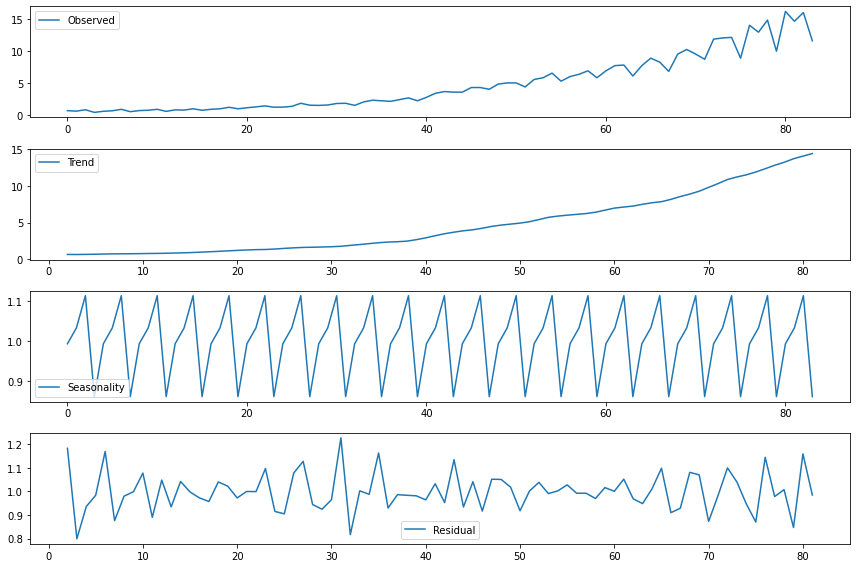

In [29]:
result = seasonal_decompose(jj_data['data'], model='multiplicative', period=4)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

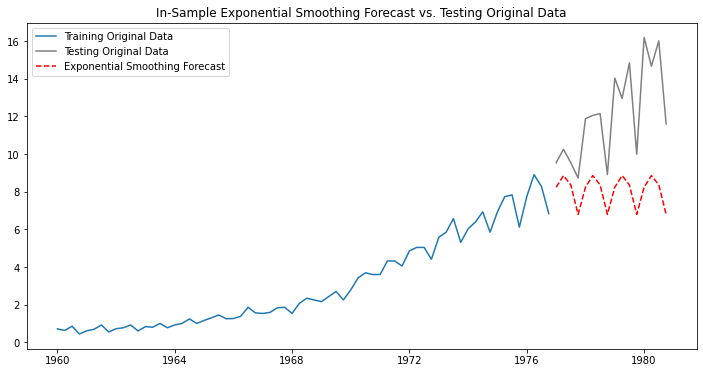

RMSE (Exponentional Smoothing): 4.560663603670137
R-squared (Exponentional Smoothing): -2.5549169439378763
MSE (Exponentional Smoothing): 20.79965250584148
MAPE (Exponentional Smoothing): 0.3128292376702754%


In [30]:
ES_model = ExponentialSmoothing(train_data, seasonal='mul', seasonal_periods=4)
results = ES_model.fit()

ES_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'][:len(train_data)].to_numpy(), train_data.to_numpy(), label='Training Original Data')
plt.plot(jj_data['date'][len(train_data):].to_numpy(), test_data.to_numpy(), label='Testing Original Data', color='gray')
plt.plot(jj_data['date'][len(train_data):].to_numpy(), ES_forecast.to_numpy(), label='Exponential Smoothing Forecast', color='red', linestyle='--')
plt.title('In-Sample Exponential Smoothing Forecast vs. Testing Original Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, ES_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, ES_forecast)
mape = mean_absolute_percentage_error(test_data, ES_forecast)

print(f"RMSE (Exponentional Smoothing): {rmse}")
print(f"R-squared (Exponentional Smoothing): {r2}")
print(f"MSE (Exponentional Smoothing): {mse}")
print(f"MAPE (Exponentional Smoothing): {mape}%")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


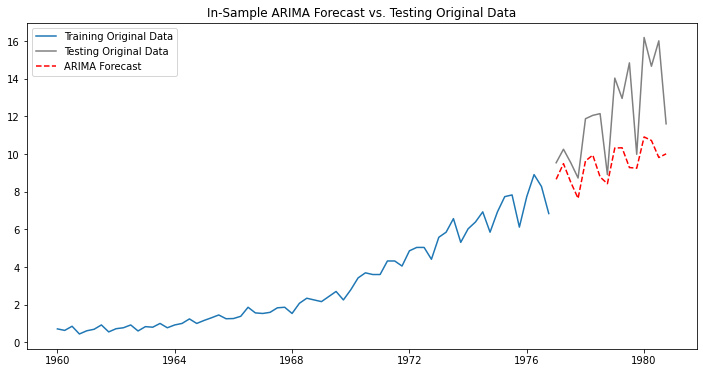

Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: (6, 1, 11)
RMSE (ARIMA): 3.1755657954688754
R-squared (ARIMA): -0.7235171527933586
MSE (ARIMA): 10.084218121351872
MAPE (ARIMA): 0.19563498086047104%


In [31]:
ARIMA_model = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q))
results = ARIMA_model.fit()

ARIMA_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'][:len(train_data)].to_numpy(), train_data.to_numpy(), label='Training Original Data')
plt.plot(jj_data['date'][len(train_data):].to_numpy(), test_data.to_numpy(), label='Testing Original Data', color='gray')
plt.plot(jj_data['date'][len(train_data):].to_numpy(), ARIMA_forecast.to_numpy(), label='ARIMA Forecast', color='red', linestyle='--')
plt.title('In-Sample ARIMA Forecast vs. Testing Original Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, ARIMA_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, ARIMA_forecast)
mape = mean_absolute_percentage_error(test_data, ARIMA_forecast)

print(f"Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: ({optimal_p}, {optimal_d}, {optimal_q})")
print(f"RMSE (ARIMA): {rmse}")
print(f"R-squared (ARIMA): {r2}")
print(f"MSE (ARIMA): {mse}")
print(f"MAPE (ARIMA): {mape}%")

In [32]:
jj_data_seasonal = seasonal_decompose(jj_data['data'], model='multiplicative', period=4).seasonal
jj_data_seasonal_stationary, optimal_D = differencing(jj_data_seasonal)

In [33]:
jj_data_seasonal_stationary = jj_data_seasonal_stationary.dropna()

In [34]:
optimal_D

0

<Figure size 864x1440 with 0 Axes>

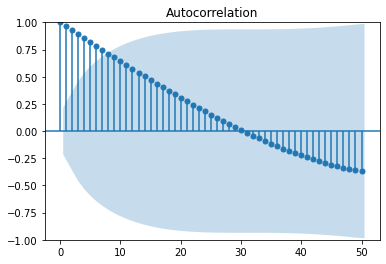

In [35]:
plt.figure(figsize=(12, 20))
plot_acf(jj_data_stationary['date'], lags=50)
plt.show()

<Figure size 864x1440 with 0 Axes>

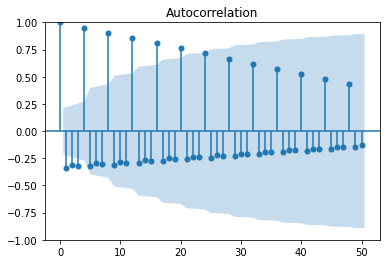

In [36]:
plt.figure(figsize=(12, 20))
plot_acf(jj_data_seasonal_stationary, lags=50)
plt.show()

<Figure size 864x1440 with 0 Axes>

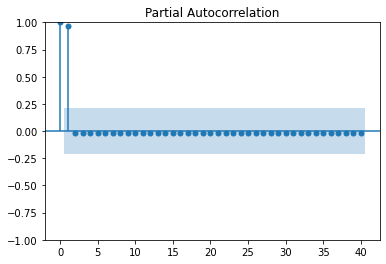

In [37]:
plt.figure(figsize=(12, 20))
plot_pacf(jj_data_stationary['date'], lags=40)
plt.show()

<Figure size 864x1440 with 0 Axes>

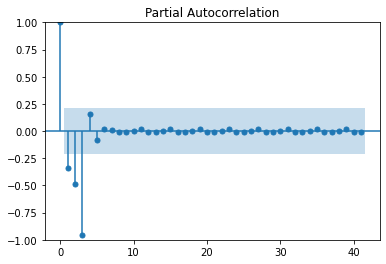

In [38]:
plt.figure(figsize=(12, 20))
plot_pacf(jj_data_seasonal_stationary, lags=41)
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


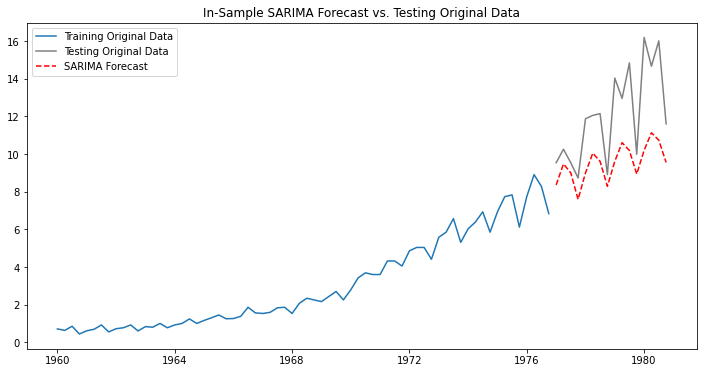

Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: (3, 1, 1)
Optimal lag order (P, D, Q) based on Seasonal PACF, ADF Test and Seasonal ACF: (1, 0, 1)
RMSE (SARIMA): 3.074623944377478
R-squared (SARIMA): -0.6156875897475387
MSE (SARIMA): 9.453312399339321
MAPE (SARIMA): 0.19421692161200688%


In [39]:
SARIMA_model = SARIMAX(train_data, order=(3, optimal_d, 1), seasonal_order = (1, optimal_D, 1, 4))
results = SARIMA_model.fit()

SARIMA_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'][:len(train_data)].to_numpy(), train_data.to_numpy(), label='Training Original Data')
plt.plot(jj_data['date'][len(train_data):].to_numpy(), test_data.to_numpy(), label='Testing Original Data', color='gray')
plt.plot(jj_data['date'][len(train_data):].to_numpy(), SARIMA_forecast.to_numpy(), label='SARIMA Forecast', color='red', linestyle='--')
plt.title('In-Sample SARIMA Forecast vs. Testing Original Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, SARIMA_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, SARIMA_forecast)
mape = mean_absolute_percentage_error(test_data, SARIMA_forecast)

print(f"Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: ({3}, {optimal_d}, {1})")
print(f"Optimal lag order (P, D, Q) based on Seasonal PACF, ADF Test and Seasonal ACF: ({1}, {optimal_D}, {1})")
print(f"RMSE (SARIMA): {rmse}")
print(f"R-squared (SARIMA): {r2}")
print(f"MSE (SARIMA): {mse}")
print(f"MAPE (SARIMA): {mape}%")

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = jj_data[:]
scaled_data = scaler.fit_transform(jj_data['data'].values.reshape(-1, 1))
data['data'] = scaled_data
print(data)

         date      data
0  1960-01-01  0.017132
1  1960-04-01  0.012056
2  1960-07-02  0.026015
3  1960-10-01  0.000000
4  1961-01-01  0.010787
..        ...       ...
79 1979-10-01  0.605964
80 1980-01-01  1.000000
81 1980-04-01  0.902919
82 1980-07-02  0.988579
83 1980-10-01  0.708756

[84 rows x 2 columns]


In [41]:
seq_len = 2

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len):
    train_end = pd.to_datetime('1976-10-01')
    n_train = len(data[data['date'] <= train_end]) - seq_len + 1
    data = data.drop(columns=['date'])
    
    sequences = split_into_sequences(data, seq_len)
    
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(data, seq_len)

In [42]:
dropout = 0.2
window_size = seq_len - 1

model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(window_size, x_train.shape[-1]))))
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))

# model = keras.Sequential()
# model.add(
#     LSTM(window_size, return_sequences=True, 
#          input_shape=(window_size, x_train.shape[-1]))
# )

# model.add(Dropout(rate=dropout))
# model.add(
#     Bidirectional(LSTM((window_size * 2), return_sequences=True)
# )) 

# model.add(Dropout(rate=dropout))
# model.add(
#     Bidirectional(LSTM(window_size, return_sequences=False))
# ) 

# model.add(Dense(units=1))
# model.add(Activation('linear'))

In [43]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=600,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/600
4/4 [==============================] - 7s 418ms/step - loss: 0.0176 - val_loss: 0.1525
Epoch 2/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0144 - val_loss: 0.1357
Epoch 3/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0116 - val_loss: 0.1190
Epoch 4/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0094 - val_loss: 0.1029
Epoch 5/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0876
Epoch 6/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0737
Epoch 7/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0617
Epoch 8/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0519
Epoch 9/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0447
Epoch 10/600
4/4 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0398
Epoch 11/600
4/4 [=========

4/4 [==============================] - 0s 9ms/step - loss: 4.6636e-04 - val_loss: 0.0055
Epoch 83/600
4/4 [==============================] - 0s 9ms/step - loss: 4.5449e-04 - val_loss: 0.0054
Epoch 84/600
4/4 [==============================] - 0s 9ms/step - loss: 5.3731e-04 - val_loss: 0.0054
Epoch 85/600
4/4 [==============================] - 0s 9ms/step - loss: 5.1156e-04 - val_loss: 0.0053
Epoch 86/600
4/4 [==============================] - 0s 9ms/step - loss: 5.3751e-04 - val_loss: 0.0051
Epoch 87/600
4/4 [==============================] - 0s 9ms/step - loss: 5.2396e-04 - val_loss: 0.0050
Epoch 88/600
4/4 [==============================] - 0s 9ms/step - loss: 4.2980e-04 - val_loss: 0.0051
Epoch 89/600
4/4 [==============================] - 0s 9ms/step - loss: 5.0206e-04 - val_loss: 0.0052
Epoch 90/600
4/4 [==============================] - 0s 8ms/step - loss: 5.1367e-04 - val_loss: 0.0051
Epoch 91/600
4/4 [==============================] - 0s 9ms/step - loss: 5.4420e-04 - val_loss: 

Epoch 162/600
4/4 [==============================] - 0s 9ms/step - loss: 5.3621e-04 - val_loss: 0.0050
Epoch 163/600
4/4 [==============================] - 0s 9ms/step - loss: 5.2178e-04 - val_loss: 0.0049
Epoch 164/600
4/4 [==============================] - 0s 9ms/step - loss: 4.5235e-04 - val_loss: 0.0049
Epoch 165/600
4/4 [==============================] - 0s 9ms/step - loss: 5.8965e-04 - val_loss: 0.0051
Epoch 166/600
4/4 [==============================] - 0s 9ms/step - loss: 4.2908e-04 - val_loss: 0.0052
Epoch 167/600
4/4 [==============================] - 0s 9ms/step - loss: 4.6522e-04 - val_loss: 0.0053
Epoch 168/600
4/4 [==============================] - 0s 9ms/step - loss: 5.2054e-04 - val_loss: 0.0053
Epoch 169/600
4/4 [==============================] - 0s 8ms/step - loss: 5.2285e-04 - val_loss: 0.0052
Epoch 170/600
4/4 [==============================] - 0s 8ms/step - loss: 5.0434e-04 - val_loss: 0.0051
Epoch 171/600
4/4 [==============================] - 0s 11ms/step - loss:

4/4 [==============================] - 0s 9ms/step - loss: 4.4953e-04 - val_loss: 0.0049
Epoch 242/600
4/4 [==============================] - 0s 9ms/step - loss: 4.0071e-04 - val_loss: 0.0047
Epoch 243/600
4/4 [==============================] - 0s 8ms/step - loss: 4.6192e-04 - val_loss: 0.0046
Epoch 244/600
4/4 [==============================] - 0s 9ms/step - loss: 5.2524e-04 - val_loss: 0.0047
Epoch 245/600
4/4 [==============================] - 0s 9ms/step - loss: 4.7817e-04 - val_loss: 0.0047
Epoch 246/600
4/4 [==============================] - 0s 9ms/step - loss: 5.5579e-04 - val_loss: 0.0047
Epoch 247/600
4/4 [==============================] - 0s 11ms/step - loss: 4.8988e-04 - val_loss: 0.0046
Epoch 248/600
4/4 [==============================] - 0s 12ms/step - loss: 5.0331e-04 - val_loss: 0.0045
Epoch 249/600
4/4 [==============================] - 0s 9ms/step - loss: 5.4232e-04 - val_loss: 0.0045
Epoch 250/600
4/4 [==============================] - 0s 9ms/step - loss: 4.5014e-04 -

4/4 [==============================] - 0s 9ms/step - loss: 3.9776e-04 - val_loss: 0.0044
Epoch 321/600
4/4 [==============================] - 0s 10ms/step - loss: 4.6921e-04 - val_loss: 0.0046
Epoch 322/600
4/4 [==============================] - 0s 9ms/step - loss: 4.2801e-04 - val_loss: 0.0046
Epoch 323/600
4/4 [==============================] - 0s 9ms/step - loss: 4.5375e-04 - val_loss: 0.0045
Epoch 324/600
4/4 [==============================] - 0s 9ms/step - loss: 4.6571e-04 - val_loss: 0.0044
Epoch 325/600
4/4 [==============================] - 0s 9ms/step - loss: 5.5256e-04 - val_loss: 0.0044
Epoch 326/600
4/4 [==============================] - 0s 9ms/step - loss: 4.1626e-04 - val_loss: 0.0044
Epoch 327/600
4/4 [==============================] - 0s 9ms/step - loss: 4.4703e-04 - val_loss: 0.0043
Epoch 328/600
4/4 [==============================] - 0s 8ms/step - loss: 4.6350e-04 - val_loss: 0.0043
Epoch 329/600
4/4 [==============================] - 0s 8ms/step - loss: 4.5499e-04 - 

4/4 [==============================] - 0s 11ms/step - loss: 4.6716e-04 - val_loss: 0.0043
Epoch 400/600
4/4 [==============================] - 0s 12ms/step - loss: 4.3809e-04 - val_loss: 0.0043
Epoch 401/600
4/4 [==============================] - 0s 10ms/step - loss: 4.5692e-04 - val_loss: 0.0043
Epoch 402/600
4/4 [==============================] - 0s 9ms/step - loss: 4.0948e-04 - val_loss: 0.0042
Epoch 403/600
4/4 [==============================] - 0s 9ms/step - loss: 4.6786e-04 - val_loss: 0.0042
Epoch 404/600
4/4 [==============================] - 0s 9ms/step - loss: 4.3130e-04 - val_loss: 0.0042
Epoch 405/600
4/4 [==============================] - 0s 10ms/step - loss: 4.4881e-04 - val_loss: 0.0042
Epoch 406/600
4/4 [==============================] - 0s 10ms/step - loss: 4.1924e-04 - val_loss: 0.0042
Epoch 407/600
4/4 [==============================] - 0s 9ms/step - loss: 3.8071e-04 - val_loss: 0.0042
Epoch 408/600
4/4 [==============================] - 0s 10ms/step - loss: 4.4193e-

4/4 [==============================] - 0s 9ms/step - loss: 5.0265e-04 - val_loss: 0.0041
Epoch 479/600
4/4 [==============================] - 0s 9ms/step - loss: 4.8280e-04 - val_loss: 0.0040
Epoch 480/600
4/4 [==============================] - 0s 9ms/step - loss: 4.2866e-04 - val_loss: 0.0040
Epoch 481/600
4/4 [==============================] - 0s 9ms/step - loss: 4.9586e-04 - val_loss: 0.0040
Epoch 482/600
4/4 [==============================] - 0s 9ms/step - loss: 4.6680e-04 - val_loss: 0.0040
Epoch 483/600
4/4 [==============================] - 0s 8ms/step - loss: 4.4609e-04 - val_loss: 0.0041
Epoch 484/600
4/4 [==============================] - 0s 9ms/step - loss: 4.7461e-04 - val_loss: 0.0041
Epoch 485/600
4/4 [==============================] - 0s 10ms/step - loss: 3.7025e-04 - val_loss: 0.0041
Epoch 486/600
4/4 [==============================] - 0s 10ms/step - loss: 3.9228e-04 - val_loss: 0.0042
Epoch 487/600
4/4 [==============================] - 0s 9ms/step - loss: 5.1116e-04 -

4/4 [==============================] - 0s 9ms/step - loss: 4.1891e-04 - val_loss: 0.0040
Epoch 558/600
4/4 [==============================] - 0s 9ms/step - loss: 4.0623e-04 - val_loss: 0.0040
Epoch 559/600
4/4 [==============================] - 0s 9ms/step - loss: 4.3880e-04 - val_loss: 0.0040
Epoch 560/600
4/4 [==============================] - 0s 9ms/step - loss: 4.7251e-04 - val_loss: 0.0040
Epoch 561/600
4/4 [==============================] - 0s 9ms/step - loss: 4.2092e-04 - val_loss: 0.0040
Epoch 562/600
4/4 [==============================] - 0s 9ms/step - loss: 5.6367e-04 - val_loss: 0.0040
Epoch 563/600
4/4 [==============================] - 0s 9ms/step - loss: 4.1445e-04 - val_loss: 0.0040
Epoch 564/600
4/4 [==============================] - 0s 9ms/step - loss: 4.7336e-04 - val_loss: 0.0040
Epoch 565/600
4/4 [==============================] - 0s 10ms/step - loss: 3.8778e-04 - val_loss: 0.0040
Epoch 566/600
4/4 [==============================] - 0s 10ms/step - loss: 4.1379e-04 -

In [44]:
y_pred = model.predict(x_test)

y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

1/1 [==============================] - 1s 1s/step


RangeIndex(start=68, stop=84, step=1)


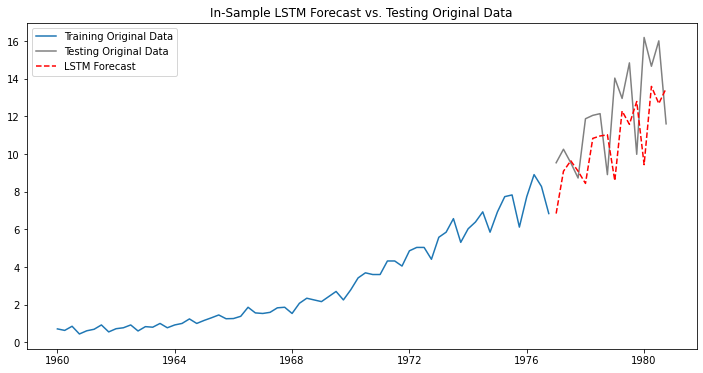

RMSE (LSTM): 2.939309372467904
R-squared (LSTM): -0.4766037873612974
MSE (LSTM): 8.639539587077662
MAPE (LSTM): 0.18607692081595684%


In [45]:
test_dates = data[-len(y_test_orig):].index

print(test_dates)

y_test_df = pd.DataFrame(y_test_orig, index=test_dates)
y_pred_df = pd.DataFrame(y_pred_orig, index=test_dates)

plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'][:len(train_data)].to_numpy(), train_data.to_numpy(), label='Training Original Data')
plt.plot(jj_data['date'][len(train_data):].to_numpy(), y_test_df.to_numpy(), label='Testing Original Data', color='gray')
plt.plot(jj_data['date'][len(train_data):].to_numpy(), y_pred_df.to_numpy(), label='LSTM Forecast', color='red', linestyle='--')

plt.title('In-Sample LSTM Forecast vs. Testing Original Data')
plt.legend()
plt.show()

mse = mean_squared_error(y_test_df, y_pred_df)
rmse = sqrt(mse)
r2 = r2_score(y_test_df, y_pred_df)
mape = mean_absolute_percentage_error(y_test_df, y_pred_df)

print(f"RMSE (LSTM): {rmse}")
print(f"R-squared (LSTM): {r2}")
print(f"MSE (LSTM): {mse}")
print(f"MAPE (LSTM): {mape}%")

In [46]:
train_data = jj_data_stationary[:]
year_1 = pd.date_range(start=train_data['date'][83], periods=5, freq='QS')[1:]
year_2 = pd.date_range(start=year_1[-1], periods=5, freq='QS')[1:]
year_3 = pd.date_range(start=year_2[-1], periods=5, freq='QS')[1:]
year_4 = pd.date_range(start=year_3[-1], periods=5, freq='QS')[1:]
full = pd.date_range(start=train_data['date'][83], periods=4*4 + 1, freq='QS')[1:]

test_data_dates = [year_1, year_2, year_3, year_4, full]
print(test_data_dates)

[DatetimeIndex(['1981-01-01', '1981-04-01', '1981-07-01', '1981-10-01'], dtype='datetime64[ns]', freq='QS-JAN'), DatetimeIndex(['1982-01-01', '1982-04-01', '1982-07-01', '1982-10-01'], dtype='datetime64[ns]', freq='QS-JAN'), DatetimeIndex(['1983-01-01', '1983-04-01', '1983-07-01', '1983-10-01'], dtype='datetime64[ns]', freq='QS-JAN'), DatetimeIndex(['1984-01-01', '1984-04-01', '1984-07-01', '1984-10-01'], dtype='datetime64[ns]', freq='QS-JAN'), DatetimeIndex(['1981-01-01', '1981-04-01', '1981-07-01', '1981-10-01',
               '1982-01-01', '1982-04-01', '1982-07-01', '1982-10-01',
               '1983-01-01', '1983-04-01', '1983-07-01', '1983-10-01',
               '1984-01-01', '1984-04-01', '1984-07-01', '1984-10-01'],
              dtype='datetime64[ns]', freq='QS-JAN')]


In [47]:
train_data = train_data.drop(columns=['date'])

In [48]:
test_data = []
year_1 = list(range(84, 88))
year_2 = list(range(88, 92))
year_3 = list(range(92, 96))
year_4 = list(list(range(96, 100)))
full = list(range(84, 100))

test_data = [year_1, year_2, year_3, year_4, full]
print(test_data)

[[84, 85, 86, 87], [88, 89, 90, 91], [92, 93, 94, 95], [96, 97, 98, 99], [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]


c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\srina\appdata\local\programs\python

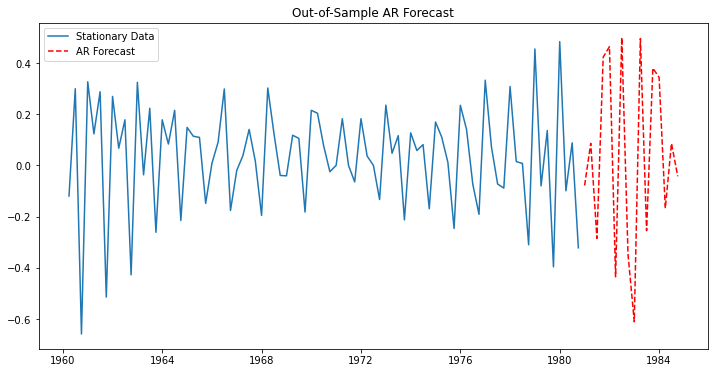

Optimal lag order (p) based on PACF: 6


In [49]:
AR_model = ARIMA(train_data, order=(optimal_p, 0, 0))
results = AR_model.fit()

AR_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
AR_forecast = pd.DataFrame(AR_forecast)
AR_forecast = AR_forecast.rename(columns={'predicted_mean': 'data'})
full_forecast = AR_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, AR_forecast])
    AR_model = ARIMA(temp, order=(optimal_p, 0, 0))
    results = AR_model.fit()

    AR_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    AR_forecast = pd.DataFrame(AR_forecast)
    AR_forecast = AR_forecast.rename(columns={'predicted_mean': 'data'})
    full_forecast = pd.concat([full_forecast, AR_forecast])

plt.figure(figsize=(12, 6))
plt.plot(jj_data_stationary['date'].to_numpy(), train_data.to_numpy(), label='Stationary Data')
plt.plot(np.array(test_data_dates[-1]), full_forecast.to_numpy(), label='AR Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample AR Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (p) based on PACF: {optimal_p}")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\srina\appdata\local\programs\python

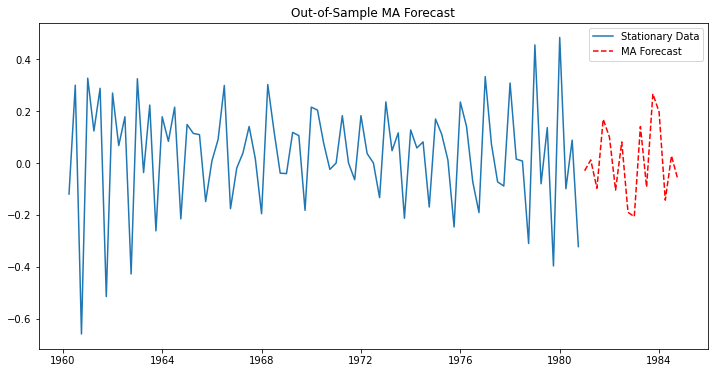

Optimal lag order (q) based on ACF: 11


In [50]:
MA_model = ARIMA(train_data, order=(0, 0, optimal_q))
results = MA_model.fit()

MA_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
MA_forecast = pd.DataFrame(MA_forecast)
MA_forecast = MA_forecast.rename(columns={'predicted_mean': 'data'})
full_forecast = MA_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, MA_forecast])
    MA_model = ARIMA(temp, order=(0, 0, optimal_q))
    results = MA_model.fit()

    MA_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    MA_forecast = pd.DataFrame(MA_forecast)
    MA_forecast = MA_forecast.rename(columns={'predicted_mean': 'data'})
    full_forecast = pd.concat([full_forecast, MA_forecast])

plt.figure(figsize=(12, 6))
plt.plot(jj_data_stationary['date'].to_numpy(), train_data.to_numpy(), label='Stationary Data')
plt.plot(np.array(test_data_dates[-1]), full_forecast.to_numpy(), label='MA Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample MA Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (q) based on ACF: {optimal_q}")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\app

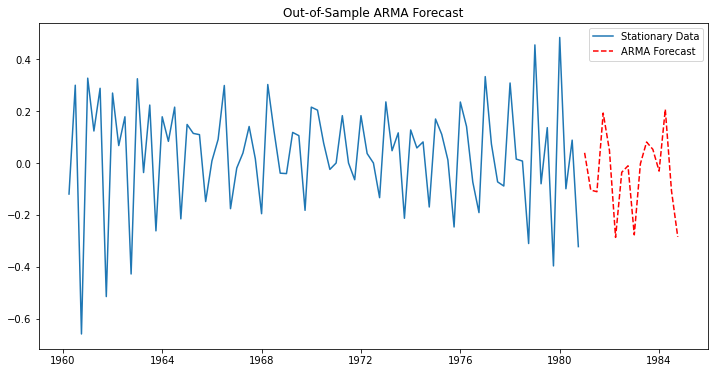

Optimal lag order (p, q) based on PACF and ACF: (6, 11)


In [51]:
ARMA_model = ARIMA(train_data, order=(optimal_p, 0, optimal_q))
results = ARMA_model.fit()

ARMA_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
ARMA_forecast = pd.DataFrame(ARMA_forecast)
ARMA_forecast = ARMA_forecast.rename(columns={'predicted_mean': 'data'})
full_forecast = ARMA_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, ARMA_forecast])
    ARMA_model = ARIMA(temp, order=(optimal_p, 0, optimal_q))
    results = ARMA_model.fit()

    ARMA_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    ARMA_forecast = pd.DataFrame(ARMA_forecast)
    ARMA_forecast = ARMA_forecast.rename(columns={'predicted_mean': 'data'})
    full_forecast = pd.concat([full_forecast, ARMA_forecast])

plt.figure(figsize=(12, 6))
plt.plot(jj_data_stationary['date'].to_numpy(), train_data.to_numpy(), label='Stationary Data')
plt.plot(np.array(test_data_dates[-1]), full_forecast.to_numpy(), label='ARMA Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample ARMA Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (p, q) based on PACF and ACF: ({optimal_p}, {optimal_q})")

In [52]:
train_data = jj_data[:]
year_1 = pd.date_range(start=train_data['date'][83], periods=5, freq='QS')[1:]
year_2 = pd.date_range(start=year_1[-1], periods=5, freq='QS')[1:]
year_3 = pd.date_range(start=year_2[-1], periods=5, freq='QS')[1:]
year_4 = pd.date_range(start=year_3[-1], periods=5, freq='QS')[1:]
full = pd.date_range(start=train_data['date'][83], periods=4*4 + 1, freq='QS')[1:]

test_data_dates = [year_1, year_2, year_3, year_4, full]
print(test_data_dates)

[DatetimeIndex(['1981-01-01', '1981-04-01', '1981-07-01', '1981-10-01'], dtype='datetime64[ns]', freq='QS-JAN'), DatetimeIndex(['1982-01-01', '1982-04-01', '1982-07-01', '1982-10-01'], dtype='datetime64[ns]', freq='QS-JAN'), DatetimeIndex(['1983-01-01', '1983-04-01', '1983-07-01', '1983-10-01'], dtype='datetime64[ns]', freq='QS-JAN'), DatetimeIndex(['1984-01-01', '1984-04-01', '1984-07-01', '1984-10-01'], dtype='datetime64[ns]', freq='QS-JAN'), DatetimeIndex(['1981-01-01', '1981-04-01', '1981-07-01', '1981-10-01',
               '1982-01-01', '1982-04-01', '1982-07-01', '1982-10-01',
               '1983-01-01', '1983-04-01', '1983-07-01', '1983-10-01',
               '1984-01-01', '1984-04-01', '1984-07-01', '1984-10-01'],
              dtype='datetime64[ns]', freq='QS-JAN')]


In [53]:
train_data = train_data.drop(columns=['date'])

In [54]:
test_data = []
year_1 = list(range(84, 88))
year_2 = list(range(88, 92))
year_3 = list(range(92, 96))
year_4 = list(list(range(96, 100)))
full = list(range(84, 100))

test_data = [year_1, year_2, year_3, year_4, full]
print(test_data)

[[84, 85, 86, 87], [88, 89, 90, 91], [92, 93, 94, 95], [96, 97, 98, 99], [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]


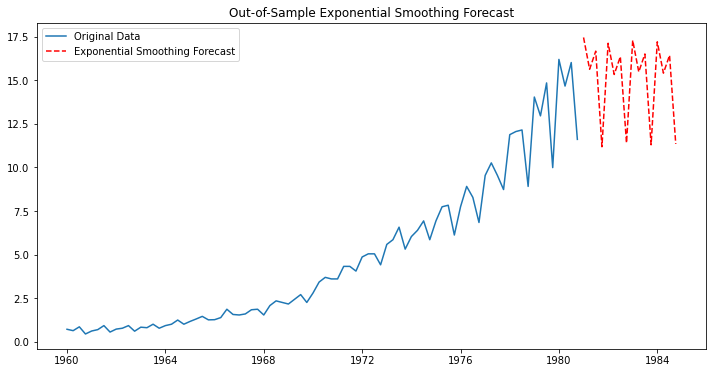

In [55]:
ES_model = ExponentialSmoothing(train_data, seasonal='mul', seasonal_periods=4)
results = ES_model.fit()

ES_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
ES_forecast = pd.DataFrame(ES_forecast, columns=['data'])
full_forecast = ES_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, ES_forecast])
    ES_model = ExponentialSmoothing(temp, seasonal='mul', seasonal_periods=4)
    results = ES_model.fit()

    ES_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    ES_forecast = pd.DataFrame(ES_forecast, columns=['data'])
    full_forecast = pd.concat([full_forecast, ES_forecast])

plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'].to_numpy(), train_data.to_numpy(), label='Original Data')
plt.plot(np.array(test_data_dates[-1]), full_forecast.to_numpy(), label='Exponential Smoothing Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample Exponential Smoothing Forecast')
plt.legend()
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as sta

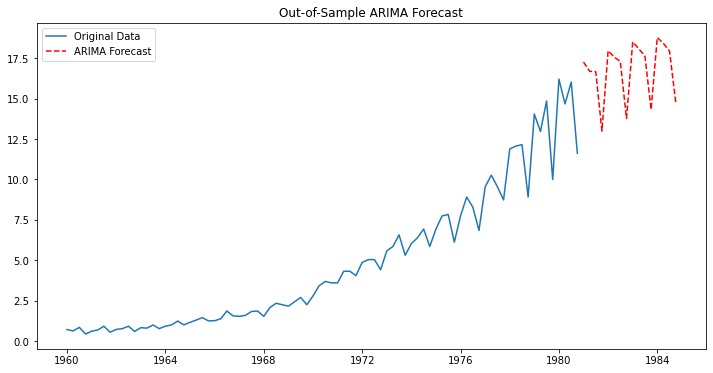

Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: (6, 1, 11)


In [56]:
ARIMA_model = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q))
results = ARIMA_model.fit()

ARIMA_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
ARIMA_forecast = pd.DataFrame(ARIMA_forecast)
ARIMA_forecast = ARIMA_forecast.rename(columns={'predicted_mean': 'data'})
full_forecast = ARIMA_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, ARIMA_forecast])
    ARIMA_model = ARIMA(temp, order=(optimal_p, optimal_d, optimal_q))
    results = ARIMA_model.fit()

    ARIMA_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    ARIMA_forecast = pd.DataFrame(ARIMA_forecast)
    ARIMA_forecast = ARIMA_forecast.rename(columns={'predicted_mean': 'data'})
    full_forecast = pd.concat([full_forecast, ARIMA_forecast])

plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'].to_numpy(), train_data.to_numpy(), label='Original Data')
plt.plot(np.array(test_data_dates[-1]), full_forecast.to_numpy(), label='ARIMA Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample ARIMA Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: ({optimal_p}, {optimal_d}, {optimal_q})")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as st

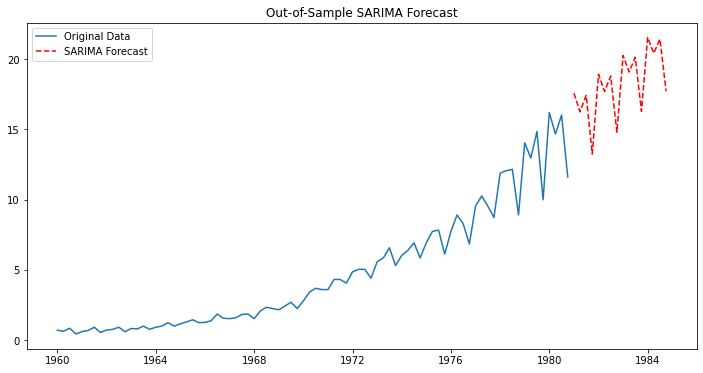

Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: (3, 1, 1)
Optimal lag order (P, D, Q) based on Seasonal PACF, ADF Test and Seasonal ACF: (1, 0, 1)


In [57]:
SARIMA_model = SARIMAX(train_data, order=(3, optimal_d, 1), seasonal_order = (1, optimal_D, 1, 4))
results = SARIMA_model.fit()

SARIMA_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
SARIMA_forecast = pd.DataFrame(SARIMA_forecast)
SARIMA_forecast = SARIMA_forecast.rename(columns={'predicted_mean': 'data'})
full_forecast = SARIMA_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, SARIMA_forecast])
    SARIMA_model = SARIMAX(temp, order=(3, optimal_d, 1), seasonal_order = (1, optimal_D, 1, 4))
    results = SARIMA_model.fit()

    SARIMA_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    SARIMA_forecast = pd.DataFrame(SARIMA_forecast)
    SARIMA_forecast = SARIMA_forecast.rename(columns={'predicted_mean': 'data'})
    full_forecast = pd.concat([full_forecast, SARIMA_forecast])

plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'].to_numpy(), train_data.to_numpy(), label='Original Data')
plt.plot(np.array(test_data_dates[-1]), full_forecast.to_numpy(), label='SARIMA Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample SARIMA Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: ({3}, {optimal_d}, {1})")
print(f"Optimal lag order (P, D, Q) based on Seasonal PACF, ADF Test and Seasonal ACF: ({1}, {optimal_D}, {1})")

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = jj_data[:]
scaled_data = scaler.fit_transform(jj_data['data'].values.reshape(-1, 1))
data['data'] = scaled_data
print(data)

         date      data
0  1960-01-01  0.017132
1  1960-04-01  0.012056
2  1960-07-02  0.026015
3  1960-10-01  0.000000
4  1961-01-01  0.010787
..        ...       ...
79 1979-10-01  0.605964
80 1980-01-01  1.000000
81 1980-04-01  0.902919
82 1980-07-02  0.988579
83 1980-10-01  0.708756

[84 rows x 2 columns]


In [59]:
seq_len = 4

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len):
    train_end = pd.to_datetime('1980-10-01')
    n_train = len(data[data['date'] <= train_end]) - seq_len + 1
    data = data.drop(columns=['date'])
    
    sequences = split_into_sequences(data, seq_len)
    
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    
    return x_train, y_train

x_train, y_train = get_train_test_sets(data, seq_len)

In [60]:
dropout = 0.2
window_size = seq_len - 1

model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(window_size, x_train.shape[-1]))))
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(units=50)))
model.add(Dense(units=1))
model.add(Activation('linear'))

# model = keras.Sequential()
# model.add(
#     LSTM(window_size, return_sequences=True, 
#          input_shape=(window_size, x_train.shape[-1]))
# )

# model.add(Dropout(rate=dropout))
# model.add(
#     Bidirectional(LSTM((window_size * 2), return_sequences=True)
# )) 

# model.add(Dropout(rate=dropout))
# model.add(
#     Bidirectional(LSTM(window_size, return_sequences=False))
# ) 

# model.add(Dense(units=1))
# model.add(Activation('linear'))

In [61]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=600,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/600
4/4 [==============================] - 12s 1s/step - loss: 0.0423 - val_loss: 0.4545
Epoch 2/600
4/4 [==============================] - 0s 15ms/step - loss: 0.0290 - val_loss: 0.3629
Epoch 3/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0187 - val_loss: 0.2679
Epoch 4/600
4/4 [==============================] - 0s 15ms/step - loss: 0.0134 - val_loss: 0.1848
Epoch 5/600
4/4 [==============================] - 0s 14ms/step - loss: 0.0133 - val_loss: 0.1307
Epoch 6/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0141 - val_loss: 0.1072
Epoch 7/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0136 - val_loss: 0.1002
Epoch 8/600
4/4 [==============================] - 0s 14ms/step - loss: 0.0103 - val_loss: 0.0927
Epoch 9/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0078 - val_loss: 0.0751
Epoch 10/600
4/4 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0485
Epoch 11/600
4/4 [==

4/4 [==============================] - 0s 13ms/step - loss: 9.8383e-04 - val_loss: 0.0216
Epoch 83/600
4/4 [==============================] - 0s 13ms/step - loss: 7.6959e-04 - val_loss: 0.0215
Epoch 84/600
4/4 [==============================] - 0s 13ms/step - loss: 9.4203e-04 - val_loss: 0.0215
Epoch 85/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0217
Epoch 86/600
4/4 [==============================] - 0s 13ms/step - loss: 9.5630e-04 - val_loss: 0.0219
Epoch 87/600
4/4 [==============================] - 0s 13ms/step - loss: 8.6237e-04 - val_loss: 0.0215
Epoch 88/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0214
Epoch 89/600
4/4 [==============================] - 0s 12ms/step - loss: 9.1937e-04 - val_loss: 0.0216
Epoch 90/600
4/4 [==============================] - 0s 13ms/step - loss: 9.1961e-04 - val_loss: 0.0217
Epoch 91/600
4/4 [==============================] - 0s 13ms/step - loss: 9.3486e-04 - val_loss

Epoch 162/600
4/4 [==============================] - 0s 13ms/step - loss: 9.3756e-04 - val_loss: 0.0234
Epoch 163/600
4/4 [==============================] - 0s 12ms/step - loss: 8.7158e-04 - val_loss: 0.0230
Epoch 164/600
4/4 [==============================] - 0s 13ms/step - loss: 9.2527e-04 - val_loss: 0.0239
Epoch 165/600
4/4 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0233
Epoch 166/600
4/4 [==============================] - 0s 13ms/step - loss: 7.6601e-04 - val_loss: 0.0235
Epoch 167/600
4/4 [==============================] - 0s 14ms/step - loss: 8.5023e-04 - val_loss: 0.0238
Epoch 168/600
4/4 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0245
Epoch 169/600
4/4 [==============================] - 0s 15ms/step - loss: 9.6355e-04 - val_loss: 0.0254
Epoch 170/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0235
Epoch 171/600
4/4 [==============================] - 0s 14ms/step - loss: 7.

4/4 [==============================] - 0s 13ms/step - loss: 9.2928e-04 - val_loss: 0.0262
Epoch 242/600
4/4 [==============================] - 0s 13ms/step - loss: 8.7610e-04 - val_loss: 0.0221
Epoch 243/600
4/4 [==============================] - 0s 13ms/step - loss: 9.6066e-04 - val_loss: 0.0236
Epoch 244/600
4/4 [==============================] - 0s 13ms/step - loss: 9.6802e-04 - val_loss: 0.0268
Epoch 245/600
4/4 [==============================] - 0s 12ms/step - loss: 7.9032e-04 - val_loss: 0.0254
Epoch 246/600
4/4 [==============================] - 0s 14ms/step - loss: 9.7122e-04 - val_loss: 0.0250
Epoch 247/600
4/4 [==============================] - 0s 14ms/step - loss: 9.4733e-04 - val_loss: 0.0225
Epoch 248/600
4/4 [==============================] - 0s 14ms/step - loss: 7.9681e-04 - val_loss: 0.0249
Epoch 249/600
4/4 [==============================] - 0s 14ms/step - loss: 8.8045e-04 - val_loss: 0.0248
Epoch 250/600
4/4 [==============================] - 0s 15ms/step - loss: 8.87

4/4 [==============================] - 0s 14ms/step - loss: 7.3765e-04 - val_loss: 0.0239
Epoch 321/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0244
Epoch 322/600
4/4 [==============================] - 0s 12ms/step - loss: 9.7739e-04 - val_loss: 0.0250
Epoch 323/600
4/4 [==============================] - 0s 13ms/step - loss: 8.0194e-04 - val_loss: 0.0260
Epoch 324/600
4/4 [==============================] - 0s 12ms/step - loss: 8.8009e-04 - val_loss: 0.0241
Epoch 325/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0240
Epoch 326/600
4/4 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0242
Epoch 327/600
4/4 [==============================] - 0s 12ms/step - loss: 9.3636e-04 - val_loss: 0.0220
Epoch 328/600
4/4 [==============================] - 0s 14ms/step - loss: 9.3091e-04 - val_loss: 0.0266
Epoch 329/600
4/4 [==============================] - 0s 13ms/step - loss: 9.0796e-04 - val

4/4 [==============================] - 0s 14ms/step - loss: 9.1672e-04 - val_loss: 0.0225
Epoch 400/600
4/4 [==============================] - 0s 14ms/step - loss: 9.5386e-04 - val_loss: 0.0225
Epoch 401/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 0.0250
Epoch 402/600
4/4 [==============================] - 0s 12ms/step - loss: 9.5383e-04 - val_loss: 0.0241
Epoch 403/600
4/4 [==============================] - 0s 13ms/step - loss: 9.9543e-04 - val_loss: 0.0239
Epoch 404/600
4/4 [==============================] - 0s 14ms/step - loss: 8.5944e-04 - val_loss: 0.0232
Epoch 405/600
4/4 [==============================] - 0s 14ms/step - loss: 9.9280e-04 - val_loss: 0.0248
Epoch 406/600
4/4 [==============================] - 0s 13ms/step - loss: 7.9120e-04 - val_loss: 0.0247
Epoch 407/600
4/4 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0240
Epoch 408/600
4/4 [==============================] - 0s 13ms/step - loss: 8.7909e-04 -

4/4 [==============================] - 0s 14ms/step - loss: 9.1603e-04 - val_loss: 0.0265
Epoch 479/600
4/4 [==============================] - 0s 15ms/step - loss: 9.3568e-04 - val_loss: 0.0232
Epoch 480/600
4/4 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 0.0231
Epoch 481/600
4/4 [==============================] - 0s 17ms/step - loss: 7.7637e-04 - val_loss: 0.0236
Epoch 482/600
4/4 [==============================] - 0s 15ms/step - loss: 9.8680e-04 - val_loss: 0.0246
Epoch 483/600
4/4 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0258
Epoch 484/600
4/4 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 0.0224
Epoch 485/600
4/4 [==============================] - 0s 19ms/step - loss: 7.7094e-04 - val_loss: 0.0233
Epoch 486/600
4/4 [==============================] - 0s 17ms/step - loss: 9.5397e-04 - val_loss: 0.0236
Epoch 487/600
4/4 [==============================] - 0s 15ms/step - loss: 8.1568e-04 - val

Epoch 558/600
4/4 [==============================] - 0s 14ms/step - loss: 9.9571e-04 - val_loss: 0.0247
Epoch 559/600
4/4 [==============================] - 0s 14ms/step - loss: 9.9977e-04 - val_loss: 0.0246
Epoch 560/600
4/4 [==============================] - 0s 16ms/step - loss: 8.5257e-04 - val_loss: 0.0257
Epoch 561/600
4/4 [==============================] - 0s 15ms/step - loss: 9.5205e-04 - val_loss: 0.0242
Epoch 562/600
4/4 [==============================] - 0s 15ms/step - loss: 9.6191e-04 - val_loss: 0.0247
Epoch 563/600
4/4 [==============================] - 0s 17ms/step - loss: 9.4012e-04 - val_loss: 0.0246
Epoch 564/600
4/4 [==============================] - 0s 15ms/step - loss: 9.7661e-04 - val_loss: 0.0239
Epoch 565/600
4/4 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0235
Epoch 566/600
4/4 [==============================] - 0s 14ms/step - loss: 9.2778e-04 - val_loss: 0.0261
Epoch 567/600
4/4 [==============================] - 0s 13ms/step - 

In [62]:
input_sequence = x_train[-1]

predicted_values = np.empty((0, 1))
for _ in range(4 * 4):
    predicted_value = model.predict(input_sequence.reshape(1, seq_len-1, 1))

    predicted_values = np.append(predicted_values, predicted_value, axis=0)

    input_sequence = np.append(input_sequence[1:], predicted_value, axis=0)

1/1 [==============================] - 0s 16ms/step


In [63]:
y_train_orig = scaler.inverse_transform(y_train)
y_pred_orig = scaler.inverse_transform(predicted_values)

DatetimeIndex(['1981-01-01', '1981-04-01', '1981-07-01', '1981-10-01',
               '1982-01-01', '1982-04-01', '1982-07-01', '1982-10-01',
               '1983-01-01', '1983-04-01', '1983-07-01', '1983-10-01',
               '1984-01-01', '1984-04-01', '1984-07-01', '1984-10-01'],
              dtype='datetime64[ns]', freq='QS-JAN')


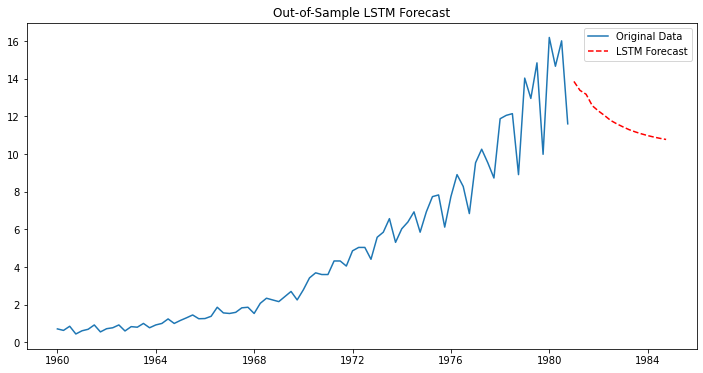

In [64]:
print(test_data_dates[-1])

y_pred_df = pd.DataFrame(y_pred_orig, index=test_data_dates[-1])

plt.figure(figsize=(12, 6))
plt.plot(jj_data['date'].to_numpy(), train_data.to_numpy(), label='Original Data')
plt.plot(np.array(test_data_dates[-1]), y_pred_df.to_numpy(), label='LSTM Forecast', color='red', linestyle='--')

plt.title('Out-of-Sample LSTM Forecast')
plt.legend()
plt.show()